In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import libraries
!pip3 install face_recognition

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import face_recognition

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.1/100.1 MB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566162 sha256=633c16b59f5d21f33b2cdf0f460e5b5f7f76d08bca5dfbfb93d2316bcf5b4edb
  Stored in directory: /root/.cache/pip/wheels/7a/eb/cf/e9eced74122b679557f597bb7c8e4c739cfcac526db1fd523d
Successfully built face-recognition-models


In [ ]:
#import libraries
import torch
from torch.autograd import Variable
import time
import os
import sys
import os
from torch import nn
from torchvision import models

In [ ]:
#Model with feature visualization
from torch import nn
from torchvision import models
class Model(nn.Module):
    def __init__(self, num_classes,latent_dim= 2048, lstm_layers=1 , hidden_dim = 2048, bidirectional = False):
        super(Model, self).__init__()
        model = models.resnext50_32x4d(pretrained = True)
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim,hidden_dim, lstm_layers,  bidirectional)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(2048,num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
    def forward(self, x):
        batch_size,seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size,seq_length,2048)
        x_lstm,_ = self.lstm(x,None)
        return fmap,self.dp(self.linear1(x_lstm[:,-1,:]))

In [ ]:
im_size = 112
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]
sm = nn.Softmax()
inv_normalize =  transforms.Normalize(mean=-1*np.divide(mean,std),std=np.divide([1,1,1],std))
def im_convert(tensor):
    """ Display a tensor as an image. """
    image = tensor.to("cpu").clone().detach()
    image = image.squeeze()
    image = inv_normalize(image)
    image = image.numpy()
    image = image.transpose(1,2,0)
    image = image.clip(0, 1)
    cv2.imwrite('./2.png',image*255)
    return image

def predict(model,img,path = './'):
  fmap,logits = model(img.to('cuda'))
  params = list(model.parameters())
  weight_softmax = model.linear1.weight.detach().cpu().numpy()
  logits = sm(logits)
  _,prediction = torch.max(logits,1)
  confidence = logits[:,int(prediction.item())].item()*100
  print('confidence of prediction:',logits[:,int(prediction.item())].item()*100)
  idx = np.argmax(logits.detach().cpu().numpy())
  bz, nc, h, w = fmap.shape
  out = np.dot(fmap[-1].detach().cpu().numpy().reshape((nc, h*w)).T,weight_softmax[idx,:].T)
  predict = out.reshape(h,w)
  predict = predict - np.min(predict)
  predict_img = predict / np.max(predict)
  predict_img = np.uint8(255*predict_img)
  out = cv2.resize(predict_img, (im_size,im_size))
  heatmap = cv2.applyColorMap(out, cv2.COLORMAP_JET)
  img = im_convert(img[:,-1,:,:,:])
  result = heatmap * 0.5 + img*0.8*255
  cv2.imwrite('/content/1.png',result)
  result1 = heatmap * 0.5/255 + img*0.8
  r,g,b = cv2.split(result1)
  result1 = cv2.merge((r,g,b))
  plt.imshow(result1)
  plt.show()
  return [int(prediction.item()),confidence]
#img = train_data[100][0].unsqueeze(0)
#predict(model,img)

In [ ]:
#!pip3 install face_recognition
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import face_recognition
class validation_dataset(Dataset):
    def __init__(self,video_names,sequence_length = 60,transform = None):
        self.video_names = video_names
        self.transform = transform
        self.count = sequence_length
    def __len__(self):
        return len(self.video_names)
    def __getitem__(self,idx):
        video_path = self.video_names[idx]
        frames = []
        a = int(100/self.count)
        first_frame = np.random.randint(0,a)
        for i,frame in enumerate(self.frame_extract(video_path)):
            #if(i % a == first_frame):
            faces = face_recognition.face_locations(frame)
            try:
              top,right,bottom,left = faces[0]
              frame = frame[top:bottom,left:right,:]
            except:
              pass
            frames.append(self.transform(frame))
            if(len(frames) == self.count):
              break
        #print("no of frames",len(frames))
        frames = torch.stack(frames)
        frames = frames[:self.count]
        return frames.unsqueeze(0)
    def frame_extract(self,path):
      vidObj = cv2.VideoCapture(path)
      success = 1
      while success:
          success, image = vidObj.read()
          if success:
              yield image
def im_plot(tensor):
    image = tensor.cpu().numpy().transpose(1,2,0)
    b,g,r = cv2.split(image)
    image = cv2.merge((r,g,b))
    image = image*[0.22803, 0.22145, 0.216989] +  [0.43216, 0.394666, 0.37645]
    image = image*255.0
    plt.imshow(image.astype(int))
    plt.show()

<ipython-input-8-f8bfbf6fa051>:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path_to_model))


/content/drive/MyDrive/Celeb-DF-v2/predict/Screenshot 2024-07-15 at 7.05.11 PM.png


confidence of prediction: 99.85941052436829


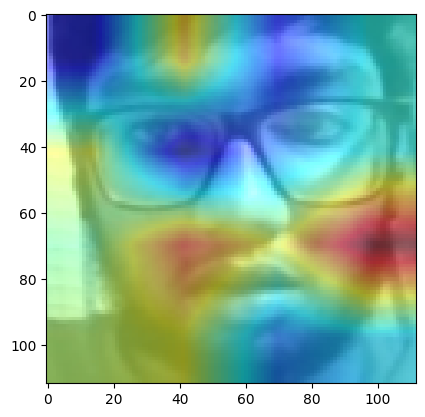

REAL
/content/drive/MyDrive/Celeb-DF-v2/predict/fake.mp4


confidence of prediction: 99.35784339904785


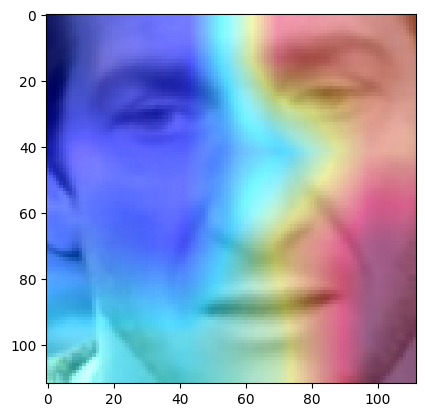

FAKE
/content/drive/MyDrive/Celeb-DF-v2/predict/real.mp4
confidence of prediction: 95.5154299736023


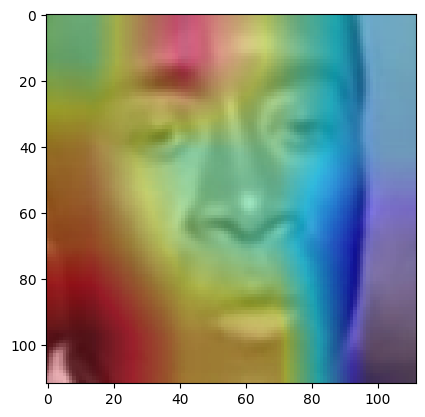

REAL


In [ ]:
#Code for making prediction
im_size = 112
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])


path_to_videos= ["/content/drive/MyDrive/Celeb-DF-v2/predict/Screenshot 2024-07-15 at 7.05.11 PM.png",
                 "/content/drive/MyDrive/Celeb-DF-v2/predict/fake.mp4",
                 "/content/drive/MyDrive/Celeb-DF-v2/predict/real.mp4"
                 ]

video_dataset = validation_dataset(path_to_videos,sequence_length = 20,transform = train_transforms)
model = Model(2).cuda()
path_to_model = '/content/drive/MyDrive/Celeb-DF-v2/checkpoint.pt'
model.load_state_dict(torch.load(path_to_model))
model.eval()
for i in range(0,len(path_to_videos)):
  print(path_to_videos[i])
  prediction = predict(model,video_dataset[i],'./')
  if prediction[0] == 1:
    print("REAL")
  else:
    print("FAKE")